In [481]:
%reset
import netCDF4
import numpy as np
import glob
import xarray as xr

import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [511]:
grdfile = '/glade/derecho/scratch/eyankovsky/EASTPAC25KM/epac25km_grd.nc'
initfile =  '/glade/derecho/scratch/eyankovsky/EASTPAC25KM/epac25km_ini.nc'

#Reading in January and Control:
infiles_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jan_combined/eastpac25km_rst.*.nc')
infiles_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Apr_combined/eastpac25km_rst.*.nc')
infiles_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jul_combined/eastpac25km_rst.*.nc')
infiles_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Oct_combined/eastpac25km_rst.*.nc')
infiles_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_1YR_combined/eastpac25km_rst.*.nc')
infiles_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_5yr_combined/eastpac25km_rst.*.nc')
infiles_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Control_combined/eastpac25km_rst.*.nc')

bgc_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jan_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Apr_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jul_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Oct_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_1YR_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_5yr_combined/eastpac25km_bgc_dia_avg.*.nc')
bgc_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Control_combined/eastpac25km_bgc_dia_avg.*.nc')

infiles_Jan.sort(); infiles_Apr.sort(); infiles_Jul.sort(); infiles_Oct.sort(); infiles_1YR.sort(); infiles_3YR.sort(); infiles_ctl.sort(); 
bgc_Jan.sort(); bgc_Apr.sort(); bgc_Jul.sort(); bgc_Oct.sort(); bgc_1YR.sort(); bgc_3YR.sort(); bgc_ctl.sort();
print('done')

done


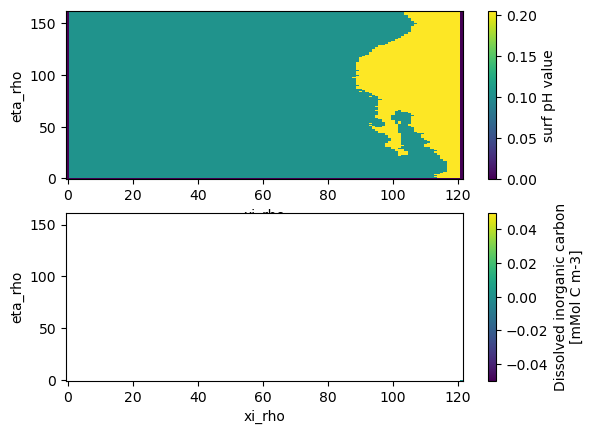

In [515]:
ii = 33
#Jan 33; Apr 33; Jul 33; Oct 33; 1YR 33; Ctl 
test1=xr.open_dataset(bgc_ctl[ii])['PH']
test2=xr.open_dataset(infiles_ctl[ii])['DIC'][0,-1,:,:]

plt.subplot(2,1,1)
test1.plot()
plt.subplot(2,1,2)
test2.plot()

In [517]:
bgc_ctl[33]

'/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Control_combined/eastpac25km_bgc_dia_avg.19991101000000.nc'

In [522]:
def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

def get_thickness(zeta, h):
    
    N = 100
    theta_s = 6
    theta_b = 6
    hc = 250

    k_w = np.linspace(0,N,N+1)

    sigma_w = (k_w - N) / N

    Cs_w = Cs(sigma_w, theta_s, theta_b)

    S_w = np.zeros((N+1, h.shape[0], h.shape[1]))

    for k in range(N+1):
        S_w[k,:,:] = (hc * sigma_w[k] + h*Cs_w[k]) / (hc + h)
                
    z_w = np.zeros((N+1, h.shape[0], h.shape[1]))
    for k in range(N+1):
        z_w[k,:,:] = zeta + (zeta + h)*S_w[k,:,:]

    H = np.diff(z_w,axis=0)
    
    return H

In [523]:
h = xr.open_dataset(grdfile)['h'][:,:]
grd = xr.open_dataset(grdfile)
dx = 1/grd.pm; dy = 1/grd.pn;
area=dx*dy

time_diff = 31.0*86400 #January
total_alk = (xr.open_dataset('ALK_forcing.nc').ALK[1,:]*time_diff)*area
total_alk = np.nansum(total_alk)

In [524]:
#ALK_forced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])
#ALK_unforced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])

time = np.zeros(len(infiles_ctl))
fraction = np.zeros(len(infiles_ctl))

ALK_diff = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

In [526]:
for index in range(33): #range(len(infiles)):
    print(index)
    ALK_forced = xr.open_dataset(infiles_Jan[index])['Alk'][1,:,:,:]
    ALK_unforced = xr.open_dataset(infiles_ctl[index])['Alk'][1,:,:,:]
    DIC_forced = xr.open_dataset(infiles_Jan[index])['DIC'][1,:,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[index])['DIC'][1,:,:,:]
    
    SSH = xr.open_dataset(infiles_ctl[index])['zeta'][1,:,:]
    H = get_thickness(SSH,h)
    
    ALK_forced_ws = (ALK_forced*H).sum(axis=0)*area     #mMol
    ALK_unforced_ws = (ALK_unforced*H).sum(axis=0)*area #mMol    
    ALK_diff[index] = ALK_forced_ws-ALK_unforced_ws

    DIC_forced_ws = (DIC_forced*H).sum(axis=0)*area     #mMol
    DIC_unforced_ws = (DIC_unforced*H).sum(axis=0)*area #mMol    
    DIC_diff[index] = DIC_forced_ws-DIC_unforced_ws

    time[index] = xr.open_dataset(infiles_ctl[index])['ocean_time'][1]


    fraction[index] = np.nansum(ALK_diff[index])/total_alk


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


Text(0, 0.5, 'Fraction')

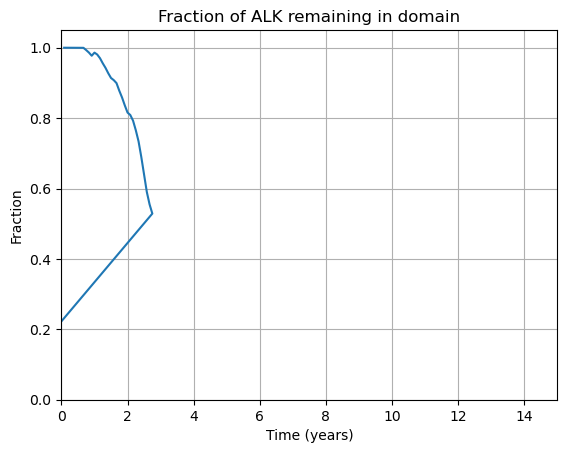

In [527]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,fraction)
plt.title('Fraction of ALK remaining in domain')
plt.grid(); plt.xlim([0,15]); plt.ylim([0,1.05]);
plt.xlabel('Time (years)'); plt.ylabel('Fraction')

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$\\eta$')

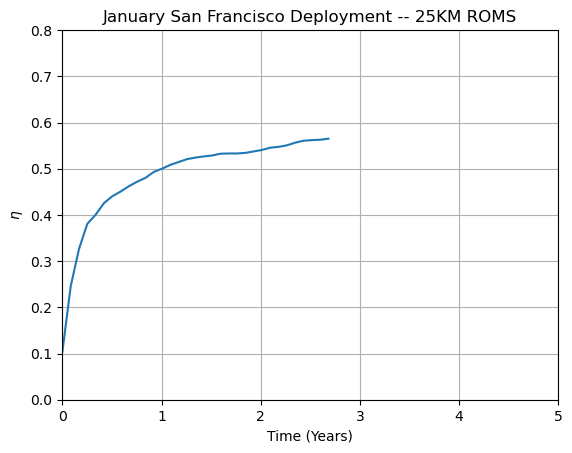

In [529]:
plt.plot(np.linspace(0,15,180),np.nansum(np.nansum(DIC_diff[0:],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff[0:],axis=1),axis=1))
plt.title('January San Francisco Deployment -- 25KM ROMS')
plt.grid(); plt.xlim([0,5]); plt.ylim([0,0.8]);
plt.xlabel('Time (Years)'); plt.ylabel('$\eta$')

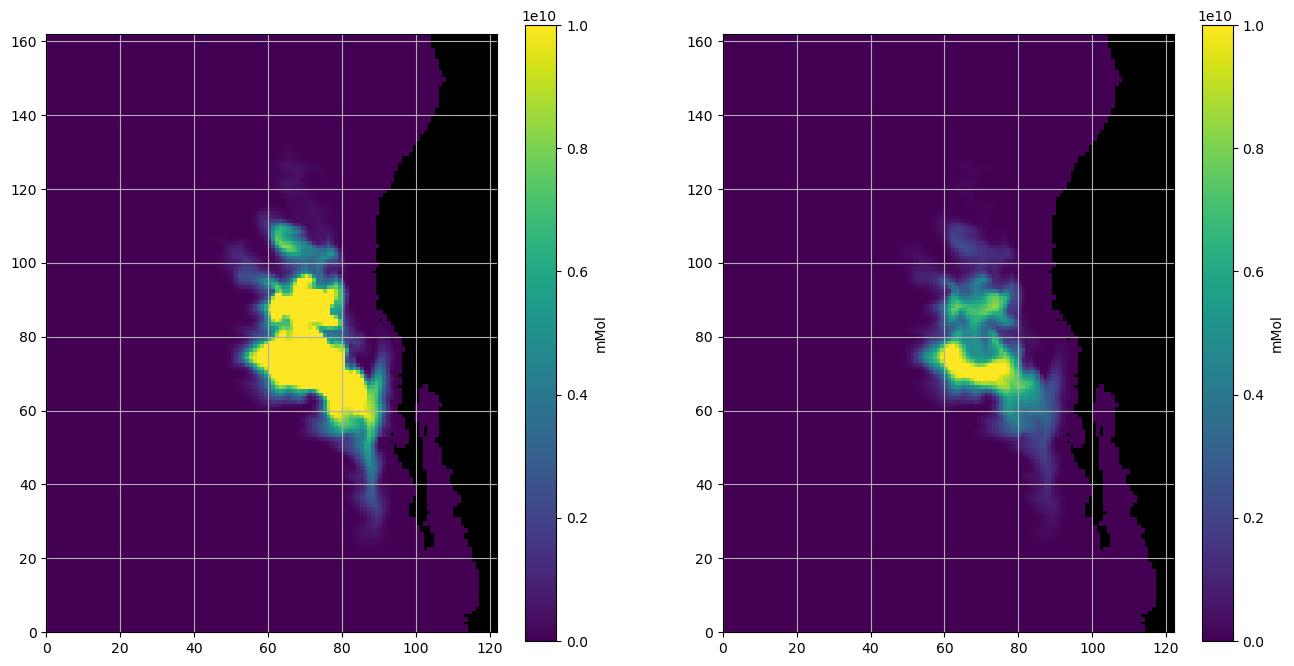

In [541]:
depth = np.ma.array(grd.mask_rho)#, mask=grd.hraw >0)
mask= grd.mask_rho.where(grd.mask_rho>0)

fig = plt.figure(figsize=(16,8),dpi=100)

i = 5
plt.subplot(1,2,1)
plt.pcolor(depth,cmap='bone')
plt.pcolor((ALK_diff[i]*mask),vmin=0,vmax=1e10)
plt.colorbar(label='mMol')
plt.gca().set_aspect('equal')
plt.grid()

plt.subplot(1,2,2)
plt.pcolor(depth,cmap='bone')
plt.pcolor((DIC_diff[i]*mask),vmin=0,vmax=1e10)
plt.colorbar(label='mMol')
plt.gca().set_aspect('equal')
plt.grid()

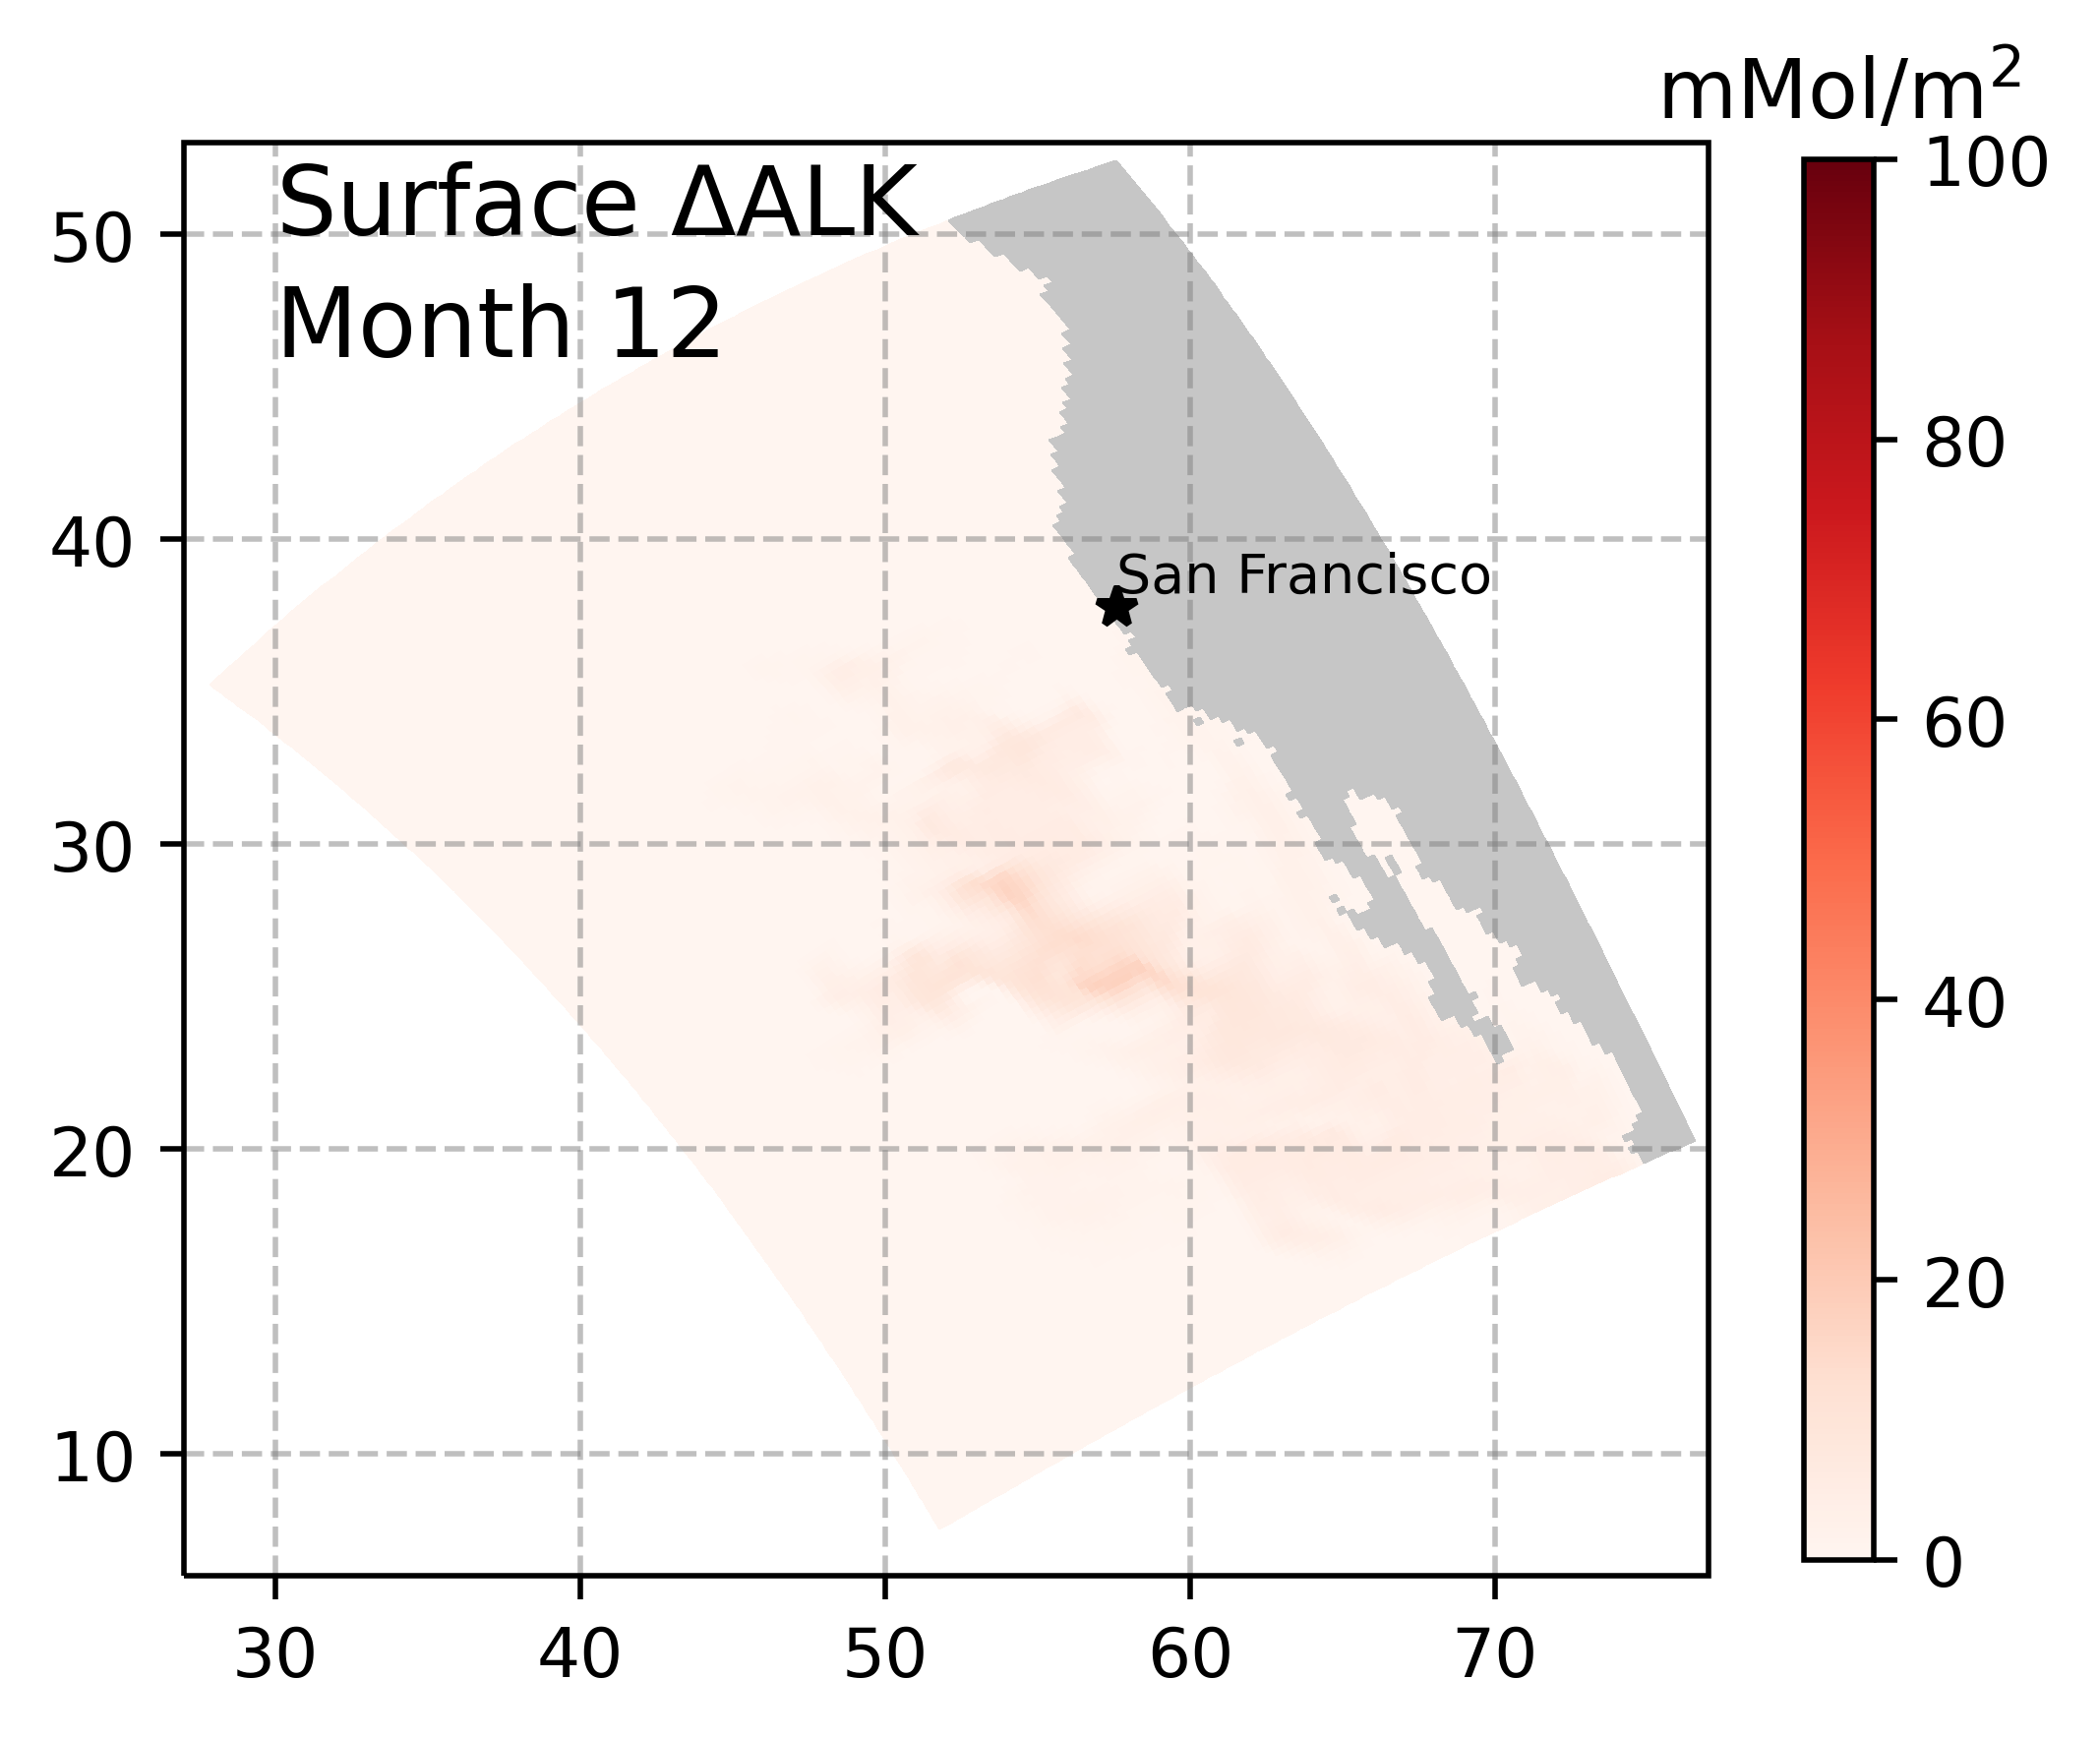

In [547]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=(5,5),dpi=500)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


ii=11
sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                ALK_diff[ii]*mask/area,
                transform=ccrs.PlateCarree(),
                vmin=0,vmax=100,cmap='Reds');
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);


cb.ax.set_title('mMol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'Surface $\Delta$ALK', fontsize=14)

plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
# plt.plot(xloc-10*resfac,yloc,'*',color='b')
# plt.contour(alk_flux[0,:])

#plt.text(xloc,yloc+2,'San Francisco',color='y')

ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)  
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
# #ax.stock_img()
#ax.add_feature(cfeature.LAND, facecolor='lightgray')

#ax.set_title('excess_ALK at surface ' + str(da.time.values[tstep])[:10], loc='left')

In [248]:
# t0 = xr.open_dataset(init_file).ocean_time
# tf = xr.open_dataset(infiles[0]).ocean_time[1]
# (tf-t0)/86400

time_diff = 31.0*86400 #January
total_alk = (xr.open_dataset('ALK_forcing.nc').ALK[1,:]*time_diff)*area
total_alk = np.nansum(total_alk)


#TO CHECK what percentage of alk we still have in the domain
np.nansum(ALK_diff[1])/total_alk


0.9999999969982313